# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
!pip install pyspark_dist_explore
from pyspark_dist_explore import hist

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# import libraries

import matplotlib.pyplot as plt
from pyspark.sql.window import Window
from pyspark.sql.functions import sum as Fsum

from pyspark.sql import SparkSession

from pyspark.sql.functions import avg, substring, col, when, desc, min, max, sum, \
split, udf, count, countDistinct, rand, struct, isnan, isnull, from_unixtime, dayofmonth, month, datediff, to_date, lit, current_date
from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType, Row, DateType
from pyspark.ml.linalg import DenseVector, SparseVector

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Spark on Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# read in the small dataset in json format
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [6]:
print('rows before dropping nans in userId and sessionId:',df.count())
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])
print('rows after dropping nans in userId and sessionId:',df.count())

rows before dropping nans in userId and sessionId: 286500
rows after dropping nans in userId and sessionId: 286500


We can see that there is no missing values in these two columns. We need to check if other columns do.

In [7]:
# get description
description = df.describe()

In [8]:
# print counts of all columns
description.show(1,vertical=True)

-RECORD 0---------------
 summary       | count  
 artist        | 228108 
 auth          | 286500 
 firstName     | 278154 
 gender        | 278154 
 itemInSession | 286500 
 lastName      | 278154 
 length        | 228108 
 level         | 286500 
 location      | 278154 
 method        | 286500 
 page          | 286500 
 registration  | 278154 
 sessionId     | 286500 
 song          | 228108 
 status        | 286500 
 ts            | 286500 
 userAgent     | 278154 
 userId        | 286500 
only showing top 1 row



It is clear that `userId` and `sessionId` do not contain missing values. We can see that `artist`, `firstName`, `gender`, `lastName`, `length`,`location`,`registration`,`song` and `userAgent` have some missing values. It seems that `firstName`, `gender`, `lastName`, `location`, `registration` and `userAgent` have the same number of missing values, probably they are having these missing values for the same reason. We print out some rows to check.

In [9]:
df.where(col('firstName').isNull()).show(5)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

Probably these are the ones that are not logged in, and the `userId` column was having empty string other than null when we tried to drop them in the frist try. Anyway, we can directly drop them since we are trying to study churn.

In [10]:
df = df.dropna(how = 'any', subset = ['firstName'])

In [11]:
# get description
description1 = df.describe()

In [12]:
# print counts of all columns
description1.show(1,vertical=True)

-RECORD 0---------------
 summary       | count  
 artist        | 228108 
 auth          | 278154 
 firstName     | 278154 
 gender        | 278154 
 itemInSession | 278154 
 lastName      | 278154 
 length        | 228108 
 level         | 278154 
 location      | 278154 
 method        | 278154 
 page          | 278154 
 registration  | 278154 
 sessionId     | 278154 
 song          | 228108 
 status        | 278154 
 ts            | 278154 
 userAgent     | 278154 
 userId        | 278154 
only showing top 1 row



Now let's check the missing values in `artist`, `length` and `song`.

In [13]:
df.where(col('artist').isNull()).show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null|Logged In|    Micah|  

These are the rows without information about the songs, like song name, artist and length. But we can still keep these row in our study.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [14]:
dfpd = df.toPandas()

In [15]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Let's check one by one.

In [16]:
# artist
# count the number of distinct artists
df.select('artist').distinct().count()

17656

In [17]:
# auth
# there are only two auth types
df.select('auth').distinct().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [18]:
# firstName
# we are not studing it here.

In [19]:
# gender
# two genders
df.select('gender').distinct().show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



In [20]:
# itemInSession
# long type, not sure for now what this means
df.select('itemInSession').distinct().show(5)

+-------------+
|itemInSession|
+-------------+
|           26|
|           29|
|          474|
|          964|
|           65|
+-------------+
only showing top 5 rows



In [21]:
# lastName
# not studied

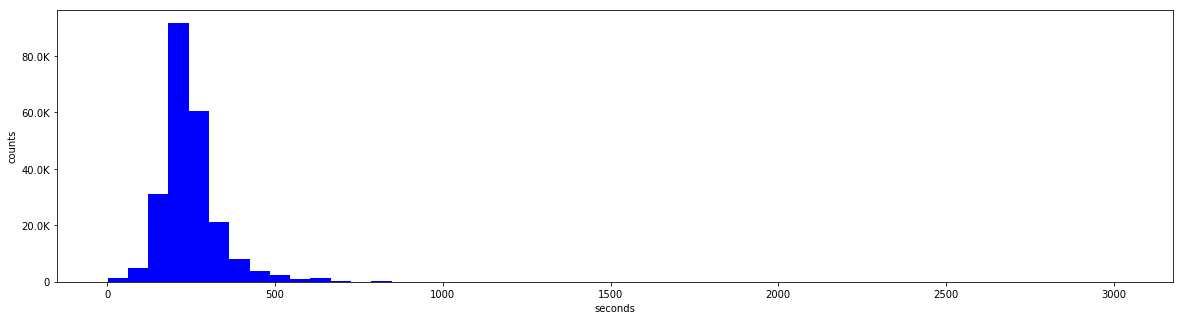

In [22]:
# length
# most songs are around 3 to 5 mins. makes sense.
fig, ax = plt.subplots(figsize=(20,5))
_ = hist(ax, df.select('length'), bins = 50, color=['blue'])
_ = plt.xlabel('seconds')
_ = plt.ylabel('counts')

In [23]:
# level
# tow levels
df.select('level').distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [24]:
# location
# at present, not sure if we can use this column
df.select('location').distinct().show(5)

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
+--------------------+
only showing top 5 rows



In [25]:
# method
# two methods
df.select('method').distinct().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [26]:
# page
df.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [27]:
# a closer look on page
df.groupby('page').count().sort('count').show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|Cancellation Conf...|    52|
|    Submit Downgrade|    63|
|      Submit Upgrade|   159|
|               Error|   252|
|       Save Settings|   310|
|               About|   495|
|             Upgrade|   499|
|                Help|  1454|
|            Settings|  1514|
|           Downgrade|  2055|
|         Thumbs Down|  2546|
|              Logout|  3226|
|         Roll Advert|  3933|
|          Add Friend|  4277|
|     Add to Playlist|  6526|
|                Home| 10082|
|           Thumbs Up| 12551|
|            NextSong|228108|
+--------------------+------+



In [28]:
# registration
df.select('registration').distinct().count()

225

In [29]:
df.select('registration').distinct().show(5)

+-------------+
| registration|
+-------------+
|1529027541000|
|1533192032000|
|1537779419000|
|1534627466000|
|1535389443000|
+-------------+
only showing top 5 rows



In [30]:
# sessionId
df.select('sessionId').distinct().count()

2312

In [31]:
# song
df.select('song').distinct().count()

58481

In [32]:
# status
df.select('status').distinct().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [33]:
# ts
df.select('ts').distinct().show(5)

+-------------+
|           ts|
+-------------+
|1538360520000|
|1538368903000|
|1538380099000|
|1538380879000|
|1538390386000|
+-------------+
only showing top 5 rows



In [34]:
# userAgent
df.select('userAgent').distinct().count()

56

In [35]:
# userId
# the number is the same as that of registration
df.select('userId').distinct().count()

225

In [36]:
df.select('userId').distinct().show(5)

+------+
|userId|
+------+
|100010|
|200002|
|   125|
|    51|
|   124|
+------+
only showing top 5 rows



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [37]:
user_window = Window \
    .partitionBy('userId')

In [38]:
function = udf(lambda hascancelled : int(hascancelled=='Cancellation Confirmation'), IntegerType())

In [39]:
df = df.withColumn('reachedcancel',function(col('page'))) \
    .withColumn('Churn',Fsum('reachedcancel').over(user_window))

In [40]:
# check the column Churn
# correct, there is no one who has reached cancellation more than once
# so we can use Churn as the label
df.select('Churn').distinct().show()

+-----+
|Churn|
+-----+
|    0|
|    1|
+-----+



In [41]:
# there are all in total 52 churn users
df.select('reachedcancel').groupBy().sum().show()

+------------------+
|sum(reachedcancel)|
+------------------+
|                52|
+------------------+



### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [42]:
# 1. number of users
numChurn = df.select('userId','Churn') \
    .dropDuplicates() \
    .groupBy('Churn') \
    .agg({'userId':'count'})

In [43]:
numChurn.show()

+-----+-------------+
|Churn|count(userId)|
+-----+-------------+
|    0|          173|
|    1|           52|
+-----+-------------+



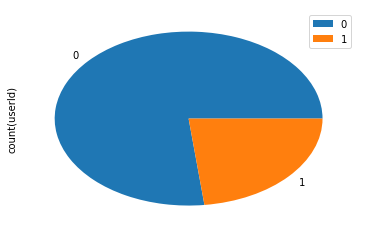

In [44]:
numChurn.toPandas().plot(x='Churn',y='count(userId)',kind='pie')

In [45]:
# 2. compared number of songs played between the two groups
# we consider only the pages marked with NextSong
# It is clear that churn users listened to much less songs than unchurn users
numSongs = df.filter(df.page=='NextSong') \
    .select('userId','Churn') \
    .groupBy('userId','Churn') \
    .agg({'Churn':'count'}) \
    .groupBy('Churn') \
    .agg({'count(Churn)':'avg'})

In [46]:
numSongs.show()

+-----+------------------+
|Churn| avg(count(Churn))|
+-----+------------------+
|    0|1108.1734104046243|
|    1| 699.8846153846154|
+-----+------------------+



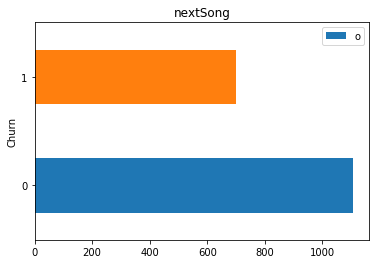

In [47]:
numSongs.toPandas().plot(x='Churn',y='avg(count(Churn))',kind='barh')
plt.title('nextSong')
_ = plt.legend('off')

In the same way, we can check different page labels one by one.

In [48]:
pagelist = df.select('page') \
    .dropDuplicates() \
    .collect()

pagelist = [p.__getitem__('page') for p in pagelist]
pagelist

['Cancel',
 'Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'Cancellation Confirmation',
 'About',
 'Settings',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade']

In [49]:
def plot_page_between_churn_notchurn(p):
    df.filter(df.page==p) \
    .select('userId','Churn') \
    .groupBy('userId','Churn') \
    .agg({'Churn':'count'}) \
    .groupBy('Churn') \
    .agg({'count(Churn)':'avg'}) \
    .toPandas() \
    .plot(x='Churn',y='avg(count(Churn))',kind='barh')
    plt.title(p)

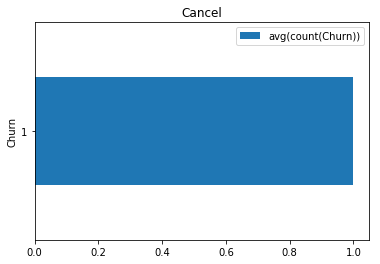

In [50]:
plot_page_between_churn_notchurn(pagelist[0])

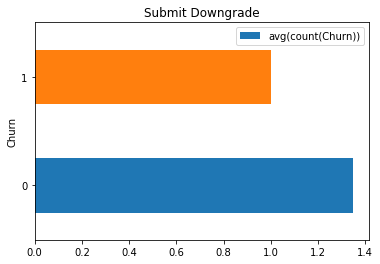

In [51]:
plot_page_between_churn_notchurn(pagelist[1])

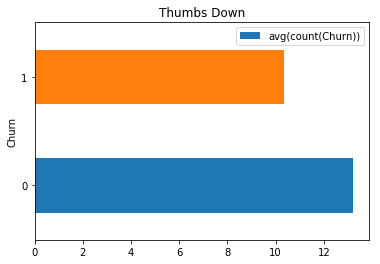

In [52]:
plot_page_between_churn_notchurn(pagelist[2])

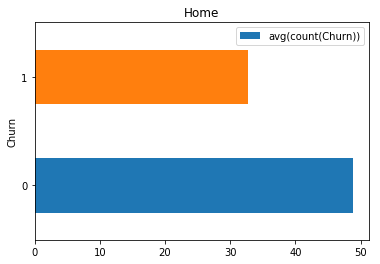

In [53]:
plot_page_between_churn_notchurn(pagelist[3])

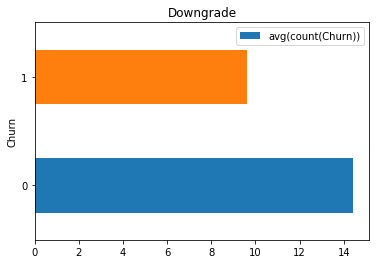

In [54]:
plot_page_between_churn_notchurn(pagelist[4])

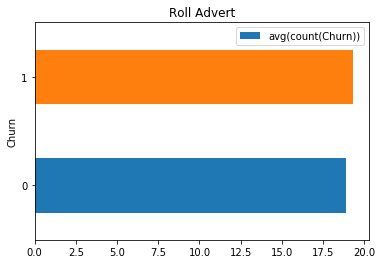

In [55]:
plot_page_between_churn_notchurn(pagelist[5])

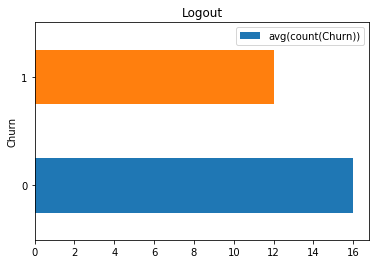

In [56]:
plot_page_between_churn_notchurn(pagelist[6])

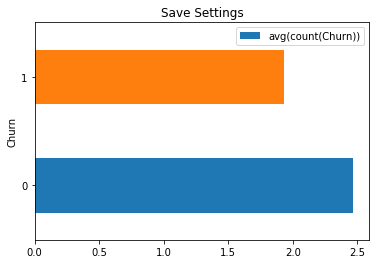

In [57]:
plot_page_between_churn_notchurn(pagelist[7])

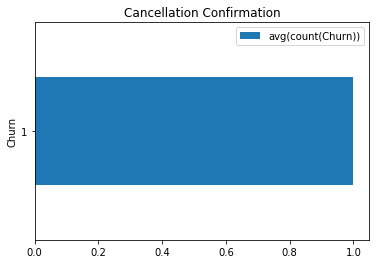

In [58]:
plot_page_between_churn_notchurn(pagelist[8])

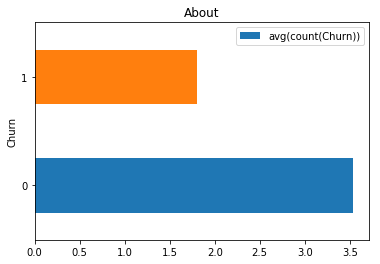

In [59]:
plot_page_between_churn_notchurn(pagelist[9])

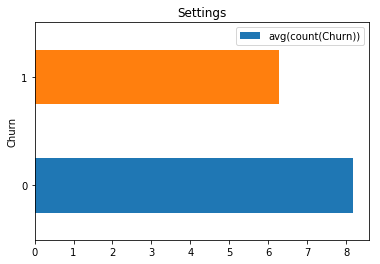

In [60]:
plot_page_between_churn_notchurn(pagelist[10])

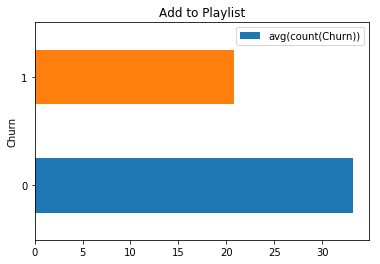

In [61]:
plot_page_between_churn_notchurn(pagelist[11])

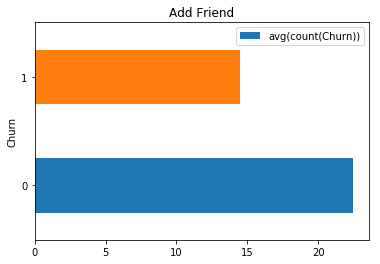

In [62]:
plot_page_between_churn_notchurn(pagelist[12])

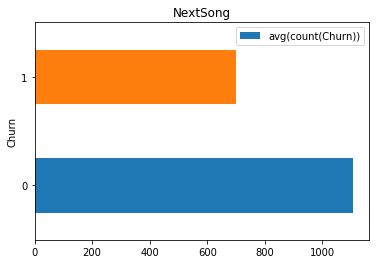

In [63]:
plot_page_between_churn_notchurn(pagelist[13])

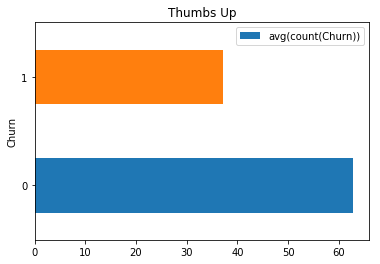

In [64]:
plot_page_between_churn_notchurn(pagelist[14])

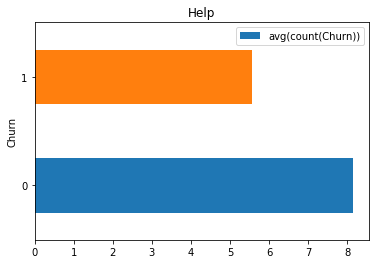

In [65]:
plot_page_between_churn_notchurn(pagelist[15])

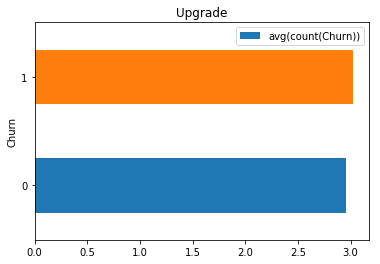

In [66]:
plot_page_between_churn_notchurn(pagelist[16])

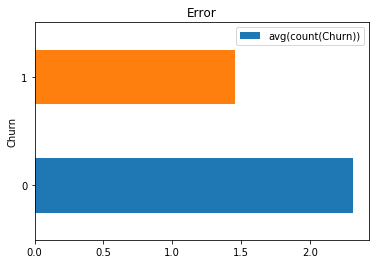

In [67]:
plot_page_between_churn_notchurn(pagelist[17])

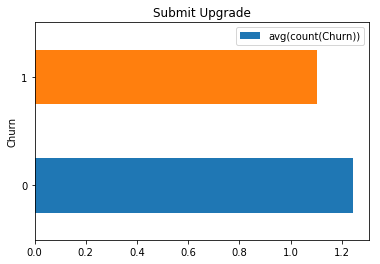

In [68]:
plot_page_between_churn_notchurn(pagelist[18])

In [69]:
# 3. compare density of action over time between the two groups
# we consider the action Thumbs Up

# get number of actions for every user
# get period of time for every user
# divide number/time

numAction_avg = df.filter(df.page=='Thumbs Up') \
    .select('userId','Churn') \
    .groupBy('userId','Churn') \
    .agg({'Churn':'count'}) \
    .groupBy('Churn') \
    .agg({'count(Churn)':'avg'})


In [70]:
numAction_avg.show()

+-----+-----------------+
|Churn|avg(count(Churn))|
+-----+-----------------+
|    0|62.89411764705882|
|    1|            37.18|
+-----+-----------------+



It makes sense that the average likes of churn users is much less than the rest. But then I realized that instead of getting the average number of thumbs up in churn/unchurn groups, I could also try the thumbs up time frequency (total amount of thumbs up divided by the total amount of time) for each group.

In [71]:
numAction = df.filter(df.page=='Thumbs Up') \
    .select('userId','Churn') \
    .groupBy('userId','Churn') \
    .agg({'Churn':'count'}) \
    .groupBy('Churn') \
    .agg({'count(Churn)':'sum'})

In [72]:
numAction.show()

+-----+-----------------+
|Churn|sum(count(Churn))|
+-----+-----------------+
|    0|            10692|
|    1|             1859|
+-----+-----------------+



In [73]:
funs = [min,max]
exprs = [f(col('ts')) for f in funs]

In [74]:
amountTime = df.filter(df.page=='Thumbs Up') \
    .select('userId','Churn','ts') \
    .groupBy('userId','Churn') \
    .agg(*exprs) \
    .withColumnRenamed('min(ts)','tsMin') \
    .withColumnRenamed('max(ts)','tsMax')

In [75]:
withDuration = amountTime.withColumn('duration',amountTime.tsMax-amountTime.tsMin)
withDuration.show(5)

+------+-----+-------------+-------------+----------+
|userId|Churn|        tsMin|        tsMax|  duration|
+------+-----+-------------+-------------+----------+
|100010|    0|1539003933000|1542821944000|3818011000|
|200002|    0|1538393807000|1542324354000|3930547000|
|   124|    0|1538419925000|1543517487000|5097562000|
|    51|    1|1538402873000|1539759213000|1356340000|
|     7|    0|1539821036000|1542955611000|3134575000|
+------+-----+-------------+-------------+----------+
only showing top 5 rows



In [76]:
timeSummed = withDuration \
    .select('Churn','duration') \
    .groupBy('Churn') \
    .sum('duration')
timeSummed.show()

+-----+-------------+
|Churn|sum(duration)|
+-----+-------------+
|    0| 636898862000|
|    1|  98058931000|
+-----+-------------+



In [77]:
sumChurnDuration = numAction.join(timeSummed,on='Churn',how='inner') \
                            .join(numChurn,on='Churn',how='inner')
sumChurnDuration.show()

+-----+-----------------+-------------+-------------+
|Churn|sum(count(Churn))|sum(duration)|count(userId)|
+-----+-----------------+-------------+-------------+
|    0|            10692| 636898862000|          173|
|    1|             1859|  98058931000|           52|
+-----+-----------------+-------------+-------------+



In [78]:
sums = sumChurnDuration.toPandas()

In [79]:
sums['likesPerDayPerUser'] = 24*3600*1000*1000*sums['sum(count(Churn))']/sums['sum(duration)']/sums['count(userId)']
sums

,Churn,sum(count(Churn)),sum(duration),count(userId),likesPerDayPerUser
0,0,10692,636898862000,173,8.384094
1,1,1859,98058931000,52,31.499426


Churn users have more thumbs up per day! Wierd. Probably not very useful in this study, but it is interesting.

In [80]:
# 4. let's take a look at the histo of the counts of unique items in some columns
def plot_histo_counts(colname):
    to_plot = df.select(colname) \
        .groupBy(colname) \
        .agg({colname:'count'})
    
    countname = 'count(%s)' %colname
    fig, ax = plt.subplots(figsize=(20,5))
    _ = hist(ax, to_plot.select(countname), bins = 50, color=['blue'])
    _ = plt.xlabel(countname)
    _ = plt.ylabel('freq of counts')
    return

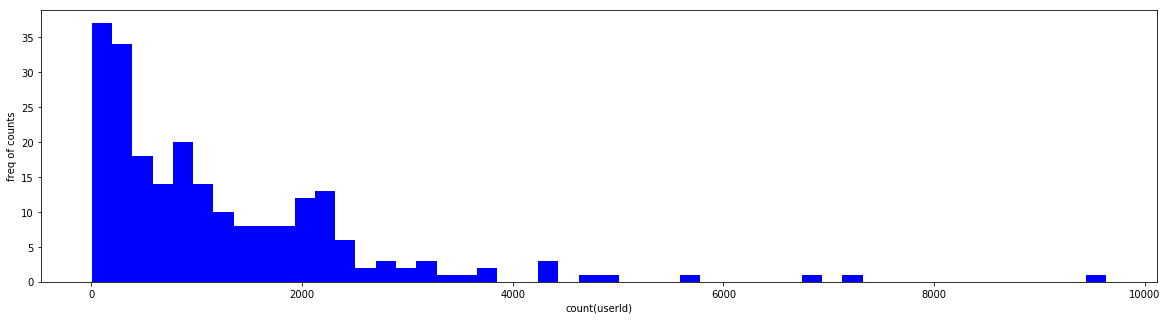

In [81]:
plot_histo_counts('userId')

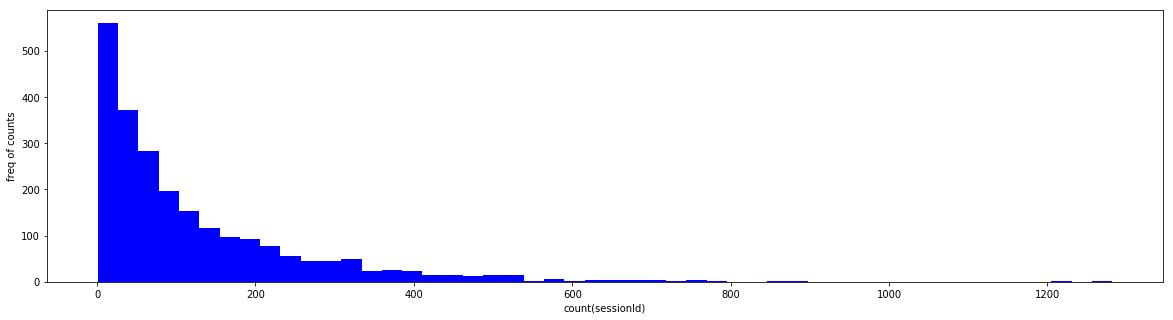

In [82]:
plot_histo_counts('sessionId')

In [83]:
# 5. time study
ts2date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d"))
df = df.withColumn('ts_date', ts2date('ts'))

In [84]:
# churn users
churnActionByDate = df.filter(df.Churn==1) \
    .groupBy('ts_date') \
    .count() \
    .orderBy(df.ts_date) \
    .toPandas()

In [85]:
# not churn users
unchurnActionByDate = df.filter(df.Churn==0) \
    .groupBy('ts_date') \
    .count() \
    .orderBy(df.ts_date) \
    .toPandas()

In [86]:
xticks = unchurnActionByDate['ts_date'].tolist()
length = len(xticks)
xticks = [xticks[i] for i in range(0,length,10)]

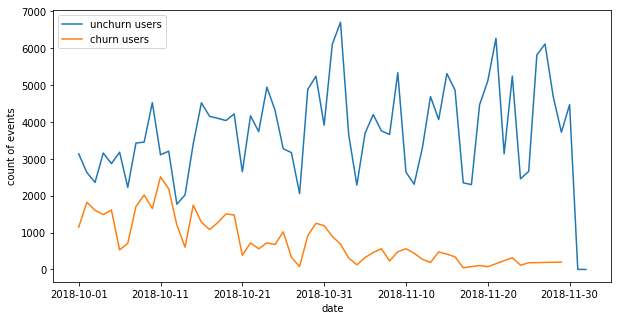

In [87]:
plt.figure(figsize=(10,5))

plt.plot(unchurnActionByDate['ts_date'],
         unchurnActionByDate['count'],label='unchurn users')
plt.plot(churnActionByDate['ts_date'],
         churnActionByDate['count'],label='churn users')

plt.legend()
plt.xlabel('date')
plt.ylabel('count of events')
_ = plt.xticks(xticks,xticks)


In [88]:
# 6. study level
df.select('level','Churn') \
    .groupBy('level','Churn') \
    .agg(count('Churn')) \
    .orderBy('level') \
    .show()

+-----+-----+------------+
|level|Churn|count(Churn)|
+-----+-----+------------+
| free|    1|       12388|
| free|    0|       43333|
| paid|    0|      189957|
| paid|    1|       32476|
+-----+-----+------------+



In [89]:
12388/(12388+43333)

0.22232192530643743

In [90]:
32476/(32476+189957)

0.14600351566539138

In [91]:
# 7. study gender
df.select('gender','Churn') \
    .groupBy('gender','Churn') \
    .agg(count('Churn')) \
    .orderBy('gender') \
    .show()

+------+-----+------------+
|gender|Churn|count(Churn)|
+------+-----+------------+
|     F|    0|      135410|
|     F|    1|       19168|
|     M|    0|       97880|
|     M|    1|       25696|
+------+-----+------------+



In [92]:
19168/(135410+19168)

0.12400212190609272

In [93]:
25696/(97880+25696)

0.20793681621026736

In [94]:
# 8. study registration
# new users tend to churn more likely
df_reg = df.select('registration','ts','userId','Churn') \
    .groupBy('userId','Churn','registration') \
    .agg(max('ts')) \
    .withColumnRenamed('max(ts)','tsMax') \
    .toPandas()

df_reg['sinceReg'] = (df_reg['tsMax']-df_reg['registration'])/1000
# df_reg

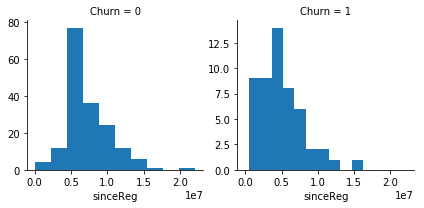

In [95]:
g = sns.FacetGrid(df_reg, col="Churn", sharey=False)
g.map(plt.hist, "sinceReg");

In [ ]:
RandomForestClassifier??